# Module Testing

Modules tested:
- Toy data generator
- MockESM
- DCCN

In [1]:
import sys
import os

root = os.path.abspath('..')
sys.path.insert(0, root)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# models
from modules.mock_esm import MockESM
from modules.dccn import DCCN_1D

# toy data generator
from tests.generate_toy_data import generate_toy_data

# linear probe  
from tests.dccn_probe import LinearProbe

In [2]:
n_samples = 50
n_go_terms = 5
min_len = 10
max_len = 20

df, go_vocab, labels = generate_toy_data(
    n_samples=n_samples, 
    n_go_terms=n_go_terms, 
    min_len=min_len, 
    max_len=max_len, 
    seed = 1000
)

In [3]:
print(go_vocab)
for i in range(3):
    print(f'{df.iloc[i]['sequence']}; {df.iloc[i]['go_terms']}')

['GO:0000001', 'GO:0000002', 'GO:0000003', 'GO:0000004', 'GO:0000005']
EPNDRGVQFIINSHNI; ['GO:0000002', 'GO:0000001']
SFRQHAVRHVGEKGLDAMAK; ['GO:0000005', 'GO:0000001']
LPMIINYSELPRN; ['GO:0000005', 'GO:0000003']


In [4]:
# Convert sequences to indices
AA_TO_IDX = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}
train_prop = 0.8
test_val_prop = 0.5

def sequence_to_indices(sequence):
    return [AA_TO_IDX[aa] for aa in sequence]

def process_sequences(sequences, max_len):
    """
    convert sequences to indices, pad to max length
    """

    padded = []
    for seq in sequences:
        tokens = sequence_to_indices(seq)
        if len(tokens) < max_len:
            tokens.extend([20] * (max_len - len(tokens)))  # 20 is the padding index
        else:
            tokens = tokens[:max_len]  # truncate to max length
        padded.append(tokens)
    
    return torch.tensor(padded, dtype=torch.long)

max_seq_len = max(len(seq) for seq in df['sequence'])
print(f"Max sequence length: {max_seq_len}")

train_seqs, test_val_seqs = train_test_split(df['sequence'], test_size=train_prop)
val_seqs, test_seqs = train_test_split(test_val_seqs, test_size=test_val_prop)

train_lab, test_val_lab = train_test_split(labels, test_size=train_prop)
val_lab, test_lab = train_test_split(test_val_lab, test_size=test_val_prop)

train_seqs_final = process_sequences(train_seqs, max_seq_len)
val_seqs_final = process_sequences(val_seqs, max_seq_len)
test_seqs_final = process_sequences(test_seqs, max_seq_len)

train_labels_final = torch.tensor(train_lab, dtype=torch.float32)
val_labels_final = torch.tensor(val_lab, dtype=torch.float32)
test_labels_final = torch.tensor(test_lab, dtype=torch.float32)

print(f'Sequence dimensions')
print(f'    Train: {train_seqs_final.shape}')
print(f'    Val: {val_seqs_final.shape}')
print(f'    Test: {test_seqs_final.shape}')
print(f'Label dimensions')
print(f'    Train: {train_labels_final.shape}')
print(f'    Val: {val_labels_final.shape}')
print(f'    Test: {test_labels_final.shape}')


Max sequence length: 20
Sequence dimensions
    Train: torch.Size([10, 20])
    Val: torch.Size([20, 20])
    Test: torch.Size([20, 20])
Label dimensions
    Train: torch.Size([10, 5])
    Val: torch.Size([20, 5])
    Test: torch.Size([20, 5])


In [5]:
# minimal hyperparameters
embed_len = 16      # ESM embedding dimension (for each amino acid)
hidden_len = 32     # MockESM hidden layer
proj_len = 24       # ESM projection dimension
go_dim = n_go_terms # output dimension

In [6]:
# initialize models
mock_esm = MockESM(
    seq_len=max_seq_len, 
    hidden_len=hidden_len, 
    embed_len=embed_len, 
    proj_len=proj_len
)

dccn = DCCN_1D(embed_len=proj_len)

linear_probe = LinearProbe(in_dim=proj_len, go_dim=go_dim)

print(f'MockESM dimensions: {embed_len} -> {hidden_len} -> {proj_len}')
print(f'DCCN dimensions: {proj_len} channels with {dccn.dilations} dilations')
print(f'LinearProbe dimensions: {proj_len} -> {go_dim}')

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\n Number of parameters:')
print(f'    MockESM: {param_count(mock_esm)}')
print(f'    DCCN: {param_count(dccn)}')
print(f'    LinearProbe: {param_count(linear_probe)}')
print(f'    Total: {param_count(mock_esm) + param_count(dccn) + param_count(linear_probe)}')


MockESM dimensions: 16 -> 32 -> 24
DCCN dimensions: 24 channels with (1, 2, 4, 8) dilations
LinearProbe dimensions: 24 -> 5

 Number of parameters:
    MockESM: 1672
    DCCN: 16512
    LinearProbe: 125
    Total: 18309


In [7]:
test_batch_seqs = train_seqs_final[:10]
test_batch_labels = train_labels_final[:10]
models = {
    'mock_esm': mock_esm,
    'dccn': dccn,
    'linear_probe': linear_probe
}

In [8]:
# test step
def test_step(seqs, labels, models):
    mock_esm, dccn, probe = models['mock_esm'], models['dccn'], models['linear_probe']
    loss_fn = nn.BCEWithLogitsLoss()

    for m in (mock_esm, dccn, probe):
        m.train()                      # enable grads
        m.zero_grad(set_to_none=True)

    # forward
    print(f"initial dimensions: {seqs.shape}")
    z = mock_esm(seqs)
    print(f"dimensions after mock_esm: {z.shape}")
    z = dccn(z)
    print(f"dimensions after dccn: {z.shape}")
    z = z.mean(dim=1)
    print(f"dimensions after mean: {z.shape}")
    logits = probe(z)
    print(f"dimensions after probe: {logits.shape}")

    # backward (without optimizer step)
    loss = loss_fn(logits, labels.float())
    loss.backward()

    # check if gradients exist
    grad_ok = all(
        p.grad is not None for m in (mock_esm, dccn, probe) for p in m.parameters() if p.requires_grad
    )

    return loss, grad_ok

loss, grad_ok = test_step(test_batch_seqs, test_batch_labels, models)
print(loss, grad_ok)

initial dimensions: torch.Size([10, 20])
dimensions after mock_esm: torch.Size([10, 20, 24])
dimensions after dccn: torch.Size([10, 20, 24])
dimensions after mean: torch.Size([10, 24])
dimensions after probe: torch.Size([10, 5])
tensor(0.8078, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) True


# SeqGating Module Testing

Testing the sequence gating mechanism that fuses ESM and DCCN embeddings with attention-based pooling.


In [ ]:
# Import SeqGating module
from modules.seq_gating import SeqGating

# Test parameters
d_shared = 128
d_esm = 1280
c_dcc = 256
attn_hidden = 128
dropout = 0.1

# Initialize SeqGating
seq_gater = SeqGating(
    d_shared=d_shared,
    d_esm=d_esm, 
    c_dcc=c_dcc,
    attn_hidden=attn_hidden,
    dropout=dropout
)

print(f"SeqGating initialized with:")
print(f"  d_shared: {d_shared}")
print(f"  d_esm: {d_esm}")
print(f"  c_dcc: {c_dcc}")
print(f"  attn_hidden: {attn_hidden}")
print(f"  dropout: {dropout}")

# Parameter count
def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nSeqGating parameters: {param_count(seq_gater)}")


SeqGating initialized with:
  d_shared: 128
  d_esm: 1280
  c_dcc: 256
  attn_hidden: 128
  dropout: 0.1

SeqGating parameters: 246401


In [10]:
# Test 1: Basic forward pass with different batch sizes and sequence lengths
torch.manual_seed(42)

# Test data
batch_sizes = [1, 4, 8]
seq_lengths = [10, 20, 50]

print("Testing SeqGating forward pass with different configurations:")
print("=" * 60)

for B in batch_sizes:
    for L in seq_lengths:
        # Generate test data
        H_esm = torch.randn(B, L, d_esm)
        H_dcc = torch.randn(B, L, c_dcc)
        lengths = torch.randint(5, L+1, (B,))
        
        # Forward pass
        output = seq_gater(H_esm, H_dcc, lengths)
        
        print(f"Batch: {B:2d}, SeqLen: {L:2d}, Lengths: {lengths.tolist()}")
        print(f"  Input shapes: ESM {H_esm.shape}, DCCN {H_dcc.shape}")
        print(f"  Output shape: {output.shape}")
        print(f"  Output stats: mean={output.mean().item():.4f}, std={output.std().item():.4f}")
        print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
        print()


Testing SeqGating forward pass with different configurations:
Batch:  1, SeqLen: 10, Lengths: [7]
  Input shapes: ESM torch.Size([1, 10, 1280]), DCCN torch.Size([1, 10, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=-0.0000, std=1.0038
  No NaN/Inf: True

Batch:  1, SeqLen: 20, Lengths: [16]
  Input shapes: ESM torch.Size([1, 20, 1280]), DCCN torch.Size([1, 20, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=-0.0000, std=1.0035
  No NaN/Inf: True

Batch:  1, SeqLen: 50, Lengths: [27]
  Input shapes: ESM torch.Size([1, 50, 1280]), DCCN torch.Size([1, 50, 256])
  Output shape: torch.Size([1, 128])
  Output stats: mean=-0.0000, std=1.0033
  No NaN/Inf: True

Batch:  4, SeqLen: 10, Lengths: [10, 6, 8, 7]
  Input shapes: ESM torch.Size([4, 10, 1280]), DCCN torch.Size([4, 10, 256])
  Output shape: torch.Size([4, 128])
  Output stats: mean=0.0000, std=1.0008
  No NaN/Inf: True

Batch:  4, SeqLen: 20, Lengths: [13, 7, 16, 8]
  Input shapes: ESM torch.Size([4, 2

In [11]:
# Test 2: Gating mechanism behavior
torch.manual_seed(42)

B, L = 2, 15
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([10, 12])

print("Testing gating mechanism:")
print("=" * 40)

# Forward pass to examine gating
with torch.no_grad():
    # Project embeddings
    E = seq_gater.proj_esm(H_esm)
    D = seq_gater.proj_dcc(H_dcc)
    
    # Generate gating weights
    gate_input = torch.cat([E, D], dim=-1)
    G = torch.sigmoid(seq_gater.gate_tok(gate_input))
    
    # Fused embeddings
    H = G * E + (1.0 - G) * D
    
    print(f"Projected ESM shape: {E.shape}")
    print(f"Projected DCCN shape: {D.shape}")
    print(f"Gating weights shape: {G.shape}")
    print(f"Gating weights range: [{G.min().item():.4f}, {G.max().item():.4f}]")
    print(f"Gating weights mean: {G.mean().item():.4f}")
    print(f"Fused embeddings shape: {H.shape}")
    
    # Check gating balance
    esm_contribution = (G * E).mean(dim=-1)
    dccn_contribution = ((1.0 - G) * D).mean(dim=-1)
    
    print(f"\nContribution analysis (per sample):")
    for i in range(B):
        print(f"  Sample {i}: ESM={esm_contribution[i].mean().item():.4f}, DCCN={dccn_contribution[i].mean().item():.4f}")
        print(f"    Gating balance: {G[i].mean().item():.4f} (0=all DCCN, 1=all ESM)")


Testing gating mechanism:
Projected ESM shape: torch.Size([2, 15, 128])
Projected DCCN shape: torch.Size([2, 15, 128])
Gating weights shape: torch.Size([2, 15, 128])
Gating weights range: [0.1902, 0.7536]
Gating weights mean: 0.5007
Fused embeddings shape: torch.Size([2, 15, 128])

Contribution analysis (per sample):
  Sample 0: ESM=0.0046, DCCN=-0.0050
    Gating balance: 0.5017 (0=all DCCN, 1=all ESM)
  Sample 1: ESM=0.0036, DCCN=0.0065
    Gating balance: 0.4997 (0=all DCCN, 1=all ESM)


In [12]:
# Test 3: Attention pooling and masking
torch.manual_seed(42)

B, L = 3, 20
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([8, 15, 20])  # Different actual lengths

print("Testing attention pooling and masking:")
print("=" * 45)

with torch.no_grad():
    # Get intermediate outputs
    E = seq_gater.proj_esm(H_esm)
    D = seq_gater.proj_dcc(H_dcc)
    G = torch.sigmoid(seq_gater.gate_tok(torch.cat([E, D], dim=-1)))
    H = G * E + (1.0 - G) * D
    
    # Attention scores
    scores = seq_gater.scorer(H)
    
    # Create mask
    mask = (torch.arange(L, device=H_esm.device)[None,:] < lengths[:,None]).unsqueeze(-1)
    scores_masked = scores.masked_fill(~mask, float('-inf'))
    w = torch.softmax(scores_masked, dim=1)
    w = torch.nan_to_num(w, nan=0.0)
    
    print(f"Attention scores shape: {scores.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Attention weights shape: {w.shape}")
    
    print(f"\nAttention weights per sample:")
    for i in range(B):
        actual_len = lengths[i].item()
        weights = w[i, :actual_len, 0]
        print(f"  Sample {i} (len={actual_len}): sum={weights.sum().item():.4f}, max={weights.max().item():.4f}")
        print(f"    Top 3 positions: {torch.topk(weights, min(3, actual_len)).indices.tolist()}")
    
    # Final output
    output = seq_gater(H_esm, H_dcc, lengths)
    print(f"\nFinal output shape: {output.shape}")
    print(f"Output stats: mean={output.mean().item():.4f}, std={output.std().item():.4f}")


Testing attention pooling and masking:
Attention scores shape: torch.Size([3, 20, 1])
Mask shape: torch.Size([3, 20, 1])
Attention weights shape: torch.Size([3, 20, 1])

Attention weights per sample:
  Sample 0 (len=8): sum=1.0000, max=0.1358
    Top 3 positions: [4, 6, 1]
  Sample 1 (len=15): sum=1.0000, max=0.0784
    Top 3 positions: [2, 1, 0]
  Sample 2 (len=20): sum=1.0000, max=0.0628
    Top 3 positions: [1, 18, 10]

Final output shape: torch.Size([3, 128])
Output stats: mean=0.0000, std=1.0010


In [13]:
# Test 4: Gradient flow and backpropagation
torch.manual_seed(42)

B, L = 4, 25
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(10, L+1, (B,))

print("Testing gradient flow:")
print("=" * 30)

# Forward pass
output = seq_gater(H_esm, H_dcc, lengths)
loss = output.sum()

# Backward pass
loss.backward()

print(f"Input gradients:")
print(f"  H_esm grad shape: {H_esm.grad.shape}")
print(f"  H_dcc grad shape: {H_dcc.grad.shape}")
print(f"  H_esm grad stats: mean={H_esm.grad.mean().item():.6f}, std={H_esm.grad.std().item():.6f}")
print(f"  H_dcc grad stats: mean={H_dcc.grad.mean().item():.6f}, std={H_dcc.grad.std().item():.6f}")

print(f"\nModel parameter gradients:")
for name, param in seq_gater.named_parameters():
    if param.grad is not None:
        print(f"  {name}: shape={param.grad.shape}, mean={param.grad.mean().item():.6f}")
    else:
        print(f"  {name}: No gradient")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in seq_gater.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

# Check gradient magnitudes
grad_norms = [p.grad.norm().item() for p in seq_gater.parameters() if p.grad is not None]
print(f"Gradient norms: {grad_norms}")


Testing gradient flow:
Input gradients:
  H_esm grad shape: torch.Size([4, 25, 1280])
  H_dcc grad shape: torch.Size([4, 25, 256])
  H_esm grad stats: mean=0.000000, std=0.000000
  H_dcc grad stats: mean=-0.000000, std=0.000000

Model parameter gradients:
  proj_esm.weight: shape=torch.Size([128, 1280]), mean=0.000000
  proj_dcc.weight: shape=torch.Size([128, 256]), mean=0.000000
  gate_tok.weight: shape=torch.Size([128, 256]), mean=-0.000000
  gate_tok.bias: shape=torch.Size([128]), mean=-0.000000
  scorer.0.weight: shape=torch.Size([128, 128]), mean=0.000000
  scorer.0.bias: shape=torch.Size([128]), mean=0.000000
  scorer.2.weight: shape=torch.Size([1, 128]), mean=0.000000
  scorer.2.bias: shape=torch.Size([1]), mean=-0.000000
  ln.weight: shape=torch.Size([128]), mean=0.000000
  ln.bias: shape=torch.Size([128]), mean=4.000000

Has NaN gradients: False
Gradient norms: [4.229839305480709e-06, 1.707879619061714e-06, 5.426753659776296e-07, 6.90208707965212e-08, 1.2995148779282317e-07, 1

In [14]:
# Test 5: Edge cases - zero lengths and extreme values
torch.manual_seed(42)

print("Testing edge cases:")
print("=" * 25)

# Test with zero length sequences
B, L = 3, 10
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.tensor([0, 5, 10])  # One zero-length sequence

print("Zero length handling:")
try:
    output = seq_gater(H_esm, H_dcc, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")

# Test with very large values
print("\nLarge value handling:")
H_esm_large = torch.randn(B, L, d_esm) * 100
H_dcc_large = torch.randn(B, L, c_dcc) * 100
lengths = torch.tensor([5, 8, 10])

try:
    output = seq_gater(H_esm_large, H_dcc_large, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  Output range: [{output.min().item():.4f}, {output.max().item():.4f}]")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")

# Test with very small values
print("\nSmall value handling:")
H_esm_small = torch.randn(B, L, d_esm) * 1e-6
H_dcc_small = torch.randn(B, L, c_dcc) * 1e-6
lengths = torch.tensor([5, 8, 10])

try:
    output = seq_gater(H_esm_small, H_dcc_small, lengths)
    print(f"  Success: output shape {output.shape}")
    print(f"  Output range: [{output.min().item():.6f}, {output.max().item():.6f}]")
    print(f"  No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")
except Exception as e:
    print(f"  Error: {e}")


Testing edge cases:
Zero length handling:
  Success: output shape torch.Size([3, 128])
  No NaN/Inf: True

Large value handling:
  Success: output shape torch.Size([3, 128])
  Output range: [-2.9110, 3.3345]
  No NaN/Inf: True

Small value handling:
  Success: output shape torch.Size([3, 128])
  Output range: [-0.000167, 0.000150]
  No NaN/Inf: True


# SeqFinal Module Testing

Testing the sequence final module that transforms sequence embeddings into GO-centric features.


In [ ]:
# Import SeqFinal module
from modules.seq_final import SeqFinal

# Test parameters for SeqFinal
d_shared = 128
n_classes = 1957
d_go = 16
p_emb = 32
n_p = 25

# Initialize SeqFinal
seq_final = SeqFinal(
    d_shared=d_shared,
    n_classes=n_classes,
    d_go=d_go,
    p_emb=p_emb,
    n_p=n_p
)

print(f"SeqFinal initialized with:")
print(f"  d_shared: {d_shared}")
print(f"  n_classes: {n_classes}")
print(f"  d_go: {d_go}")
print(f"  p_emb: {p_emb}")
print(f"  n_p: {n_p}")

print(f"\nSeqFinal parameters: {param_count(seq_final)}")

# Create sample GO embeddings
go_embed = torch.randn(n_classes, d_go)
print(f"\nGO embeddings shape: {go_embed.shape}")


SeqFinal initialized with:
  d_shared: 128
  n_classes: 1957
  d_go: 16
  p_emb: 32
  n_p: 25

SeqFinal parameters: 11956

GO embeddings shape: torch.Size([1957, 16])


In [16]:
# Test 1: Basic forward pass for SeqFinal
torch.manual_seed(42)

# Create sample sequence embeddings
x = torch.randn(n_p, d_shared)

print("Testing SeqFinal forward pass:")
print("=" * 35)

# Forward pass
output = seq_final(x, go_embed)

print(f"Input sequence embeddings shape: {x.shape}")
print(f"GO embeddings shape: {go_embed.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: ({n_p}, {n_classes}, {p_emb + d_go})")

# Verify output dimensions
expected_shape = (n_p, n_classes, p_emb + d_go)
assert output.shape == expected_shape, f"Expected {expected_shape}, got {output.shape}"

print(f"✓ Output shape correct: {output.shape}")
print(f"Output stats: mean={output.mean().item():.4f}, std={output.std().item():.4f}")
print(f"No NaN/Inf: {not torch.isnan(output).any() and not torch.isinf(output).any()}")


Testing SeqFinal forward pass:
Input sequence embeddings shape: torch.Size([25, 128])
GO embeddings shape: torch.Size([1957, 16])
Output shape: torch.Size([25, 1957, 48])
Expected output shape: (25, 1957, 48)
✓ Output shape correct: torch.Size([25, 1957, 48])
Output stats: mean=-0.0000, std=1.0000
No NaN/Inf: True


In [17]:
# Test 2: SeqFinal internal transformations
torch.manual_seed(42)

x = torch.randn(n_p, d_shared)

print("Testing SeqFinal internal transformations:")
print("=" * 45)

with torch.no_grad():
    # Step 1: Unsqueeze
    x1 = x.unsqueeze(-1)
    print(f"After unsqueeze: {x1.shape}")
    
    # Step 2: GO expansion
    x2 = seq_final.go_expand(x1)
    print(f"After go_expand: {x2.shape}")
    
    # Step 3: Transpose
    x3 = x2.transpose(-2, -1)
    print(f"After transpose: {x3.shape}")
    
    # Step 4: GO fit
    x4 = seq_final.go_fit(x3)
    print(f"After go_fit: {x4.shape}")
    
    # Step 5: GO embedding expansion
    go_embed_expanded = go_embed.unsqueeze(0).expand(n_p, -1, -1)
    print(f"GO embeddings expanded: {go_embed_expanded.shape}")
    
    # Step 6: Concatenation
    x5 = torch.cat([x4, go_embed_expanded], dim=-1)
    print(f"After concatenation: {x5.shape}")
    
    # Step 7: Batch normalization
    x6 = seq_final.batch_norm(x5)
    print(f"After batch_norm: {x6.shape}")
    
    print(f"\nFinal output matches expected: {x6.shape == (n_p, n_classes, p_emb + d_go)}")


Testing SeqFinal internal transformations:
After unsqueeze: torch.Size([25, 128, 1])
After go_expand: torch.Size([25, 128, 1957])
After transpose: torch.Size([25, 1957, 128])
After go_fit: torch.Size([25, 1957, 32])
GO embeddings expanded: torch.Size([25, 1957, 16])
After concatenation: torch.Size([25, 1957, 48])
After batch_norm: torch.Size([25, 1957, 48])

Final output matches expected: True


In [18]:
# Test 3: Gradient flow for SeqFinal
torch.manual_seed(42)

x = torch.randn(n_p, d_shared, requires_grad=True)
go_embed = torch.randn(n_classes, d_go, requires_grad=True)

print("Testing SeqFinal gradient flow:")
print("=" * 35)

# Forward pass
output = seq_final(x, go_embed)
loss = output.sum()

# Backward pass
loss.backward()

print(f"Input gradients:")
print(f"  x grad shape: {x.grad.shape}")
print(f"  go_embed grad shape: {go_embed.grad.shape}")
print(f"  x grad stats: mean={x.grad.mean().item():.6f}, std={x.grad.std().item():.6f}")
print(f"  go_embed grad stats: mean={go_embed.grad.mean().item():.6f}, std={go_embed.grad.std().item():.6f}")

print(f"\nModel parameter gradients:")
for name, param in seq_final.named_parameters():
    if param.grad is not None:
        print(f"  {name}: shape={param.grad.shape}, mean={param.grad.mean().item():.6f}")
    else:
        print(f"  {name}: No gradient")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in seq_final.parameters() if p.grad is not None)
print(f"\nHas NaN gradients: {has_nan}")

# Check gradient magnitudes
grad_norms = [p.grad.norm().item() for p in seq_final.parameters() if p.grad is not None]
print(f"Gradient norms: {grad_norms}")


Testing SeqFinal gradient flow:
Input gradients:
  x grad shape: torch.Size([25, 128])
  go_embed grad shape: torch.Size([1957, 16])
  x grad stats: mean=0.000000, std=0.000000
  go_embed grad stats: mean=-0.000000, std=0.000000

Model parameter gradients:
  go_expand.weight: shape=torch.Size([1957, 1]), mean=-0.000000
  go_expand.bias: shape=torch.Size([1957]), mean=-0.000000
  go_fit.weight: shape=torch.Size([32, 128]), mean=-0.000000
  go_fit.bias: shape=torch.Size([32]), mean=0.000001
  batch_norm.weight: shape=torch.Size([1957]), mean=0.000000
  batch_norm.bias: shape=torch.Size([1957]), mean=1200.000000

Has NaN gradients: False
Gradient norms: [9.552259871270508e-05, 0.0001279903663089499, 0.0003940772148780525, 1.7201737136929296e-05, 0.00036335227196104825, 53085.58984375]


In [19]:
# Test 4: Different batch sizes and parameter configurations
torch.manual_seed(42)

print("Testing SeqFinal with different configurations:")
print("=" * 50)

# Test different n_p values
for test_n_p in [1, 10, 50]:
    # Create new model with different n_p
    test_seq_final = SeqFinal(
        d_shared=d_shared,
        n_classes=n_classes,
        d_go=d_go,
        p_emb=p_emb,
        n_p=test_n_p
    )
    
    x_test = torch.randn(test_n_p, d_shared)
    go_embed_test = torch.randn(n_classes, d_go)
    
    output = test_seq_final(x_test, go_embed_test)
    expected_shape = (test_n_p, n_classes, p_emb + d_go)
    
    print(f"n_p={test_n_p:2d}: input={x_test.shape}, output={output.shape}, expected={expected_shape}")
    assert output.shape == expected_shape, f"Shape mismatch for n_p={test_n_p}"

# Test different d_shared values
for test_d_shared in [64, 256, 512]:
    test_seq_final = SeqFinal(
        d_shared=test_d_shared,
        n_classes=n_classes,
        d_go=d_go,
        p_emb=p_emb,
        n_p=n_p
    )
    
    x_test = torch.randn(n_p, test_d_shared)
    go_embed_test = torch.randn(n_classes, d_go)
    
    output = test_seq_final(x_test, go_embed_test)
    expected_shape = (n_p, n_classes, p_emb + d_go)
    
    print(f"d_shared={test_d_shared:3d}: input={x_test.shape}, output={output.shape}, expected={expected_shape}")
    assert output.shape == expected_shape, f"Shape mismatch for d_shared={test_d_shared}"

print("\n✓ All configuration tests passed!")


Testing SeqFinal with different configurations:
n_p= 1: input=torch.Size([1, 128]), output=torch.Size([1, 1957, 48]), expected=(1, 1957, 48)
n_p=10: input=torch.Size([10, 128]), output=torch.Size([10, 1957, 48]), expected=(10, 1957, 48)
n_p=50: input=torch.Size([50, 128]), output=torch.Size([50, 1957, 48]), expected=(50, 1957, 48)
d_shared= 64: input=torch.Size([25, 64]), output=torch.Size([25, 1957, 48]), expected=(25, 1957, 48)
d_shared=256: input=torch.Size([25, 256]), output=torch.Size([25, 1957, 48]), expected=(25, 1957, 48)
d_shared=512: input=torch.Size([25, 512]), output=torch.Size([25, 1957, 48]), expected=(25, 1957, 48)

✓ All configuration tests passed!


# Classification Probe for SeqGating + SeqFinal

Creating a probe to test the integration of SeqGating and SeqFinal modules for actual classification tasks.


In [ ]:
# Create a classification probe that integrates SeqGating and SeqFinal
class ClassificationProbe(nn.Module):
    """
    Probe that integrates SeqGating and SeqFinal for GO term classification.
    """
    def __init__(self, d_esm=1280, c_dcc=256, d_shared=128, n_classes=1957, d_go=16, p_emb=32, n_p=25):
        super().__init__()
        
        self.seq_gater = SeqGating(
            d_shared=d_shared,
            d_esm=d_esm,
            c_dcc=c_dcc,
            attn_hidden=128,
            dropout=0.1
        )
        
        self.seq_final = SeqFinal(
            d_shared=d_shared,
            n_classes=n_classes,
            d_go=d_go,
            p_emb=p_emb,
            n_p=n_p
        )
        
        # Classification head
        self.classifier = nn.Linear(p_emb + d_go, 1)
        
    def forward(self, H_esm, H_dcc, lengths, go_embed):
        """
        Forward pass through the complete pipeline.
        
        Args:
            H_esm: ESM embeddings (N, L, d_esm)
            H_dcc: DCCN embeddings (N, L, c_dcc) 
            lengths: Sequence lengths (N,)
            go_embed: GO embeddings (n_classes, d_go)
            
        Returns:
            logits: Classification logits (N, n_classes)
        """
        # Sequence gating
        seq_embeddings = self.seq_gater(H_esm, H_dcc, lengths)  # (N, d_shared)
        
        # Expand to n_p for SeqFinal (assuming we want to process each sample)
        if seq_embeddings.shape[0] != self.seq_final.n_p:
            # For testing, we'll pad or truncate to match n_p
            if seq_embeddings.shape[0] < self.seq_final.n_p:
                # Pad with zeros
                padding = torch.zeros(self.seq_final.n_p - seq_embeddings.shape[0], 
                                    seq_embeddings.shape[1], device=seq_embeddings.device)
                seq_embeddings = torch.cat([seq_embeddings, padding], dim=0)
            else:
                # Truncate
                seq_embeddings = seq_embeddings[:self.seq_final.n_p]
        
        # GO-centric features
        go_features = self.seq_final(seq_embeddings, go_embed)  # (n_p, n_classes, p_emb + d_go)
        
        # Classification
        logits = self.classifier(go_features)  # (n_p, n_classes, 1)
        logits = logits.squeeze(-1)  # (n_p, n_classes)
        
        # Return only the original batch size
        return logits[:H_esm.shape[0]]

# Initialize the probe
probe = ClassificationProbe(
    d_esm=d_esm,
    c_dcc=c_dcc,
    d_shared=d_shared,
    n_classes=n_go_terms,  # Use our toy data GO terms
    d_go=16,
    p_emb=32,
    n_p=25
)

print(f"ClassificationProbe initialized:")
print(f"  Total parameters: {param_count(probe)}")
print(f"  SeqGating parameters: {param_count(probe.seq_gater)}")
print(f"  SeqFinal parameters: {param_count(probe.seq_final)}")
print(f"  Classifier parameters: {param_count(probe.classifier)}")


ClassificationProbe initialized:
  Total parameters: 250598
  SeqGating parameters: 246401
  SeqFinal parameters: 4148
  Classifier parameters: 49


In [21]:
# Test the complete classification pipeline
torch.manual_seed(42)

# Create test data
B, L = 8, 20
H_esm = torch.randn(B, L, d_esm)
H_dcc = torch.randn(B, L, c_dcc)
lengths = torch.randint(10, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16)  # GO embeddings for our toy data

print("Testing complete classification pipeline:")
print("=" * 45)

# Forward pass
logits = probe(H_esm, H_dcc, lengths, go_embed)

print(f"Input shapes:")
print(f"  H_esm: {H_esm.shape}")
print(f"  H_dcc: {H_dcc.shape}")
print(f"  lengths: {lengths.shape}")
print(f"  go_embed: {go_embed.shape}")

print(f"\nOutput shape: {logits.shape}")
print(f"Expected shape: ({B}, {n_go_terms})")

# Test with different batch sizes
print(f"\nTesting different batch sizes:")
for test_B in [1, 4, 12]:
    H_esm_test = torch.randn(test_B, L, d_esm)
    H_dcc_test = torch.randn(test_B, L, c_dcc)
    lengths_test = torch.randint(5, L+1, (test_B,))
    
    logits_test = probe(H_esm_test, H_dcc_test, lengths_test, go_embed)
    print(f"  Batch {test_B:2d}: input={H_esm_test.shape}, output={logits_test.shape}")

print(f"\nLogits stats: mean={logits.mean().item():.4f}, std={logits.std().item():.4f}")
print(f"No NaN/Inf: {not torch.isnan(logits).any() and not torch.isinf(logits).any()}")


Testing complete classification pipeline:
Input shapes:
  H_esm: torch.Size([8, 20, 1280])
  H_dcc: torch.Size([8, 20, 256])
  lengths: torch.Size([8])
  go_embed: torch.Size([5, 16])

Output shape: torch.Size([8, 5])
Expected shape: (8, 5)

Testing different batch sizes:
  Batch  1: input=torch.Size([1, 20, 1280]), output=torch.Size([1, 5])
  Batch  4: input=torch.Size([4, 20, 1280]), output=torch.Size([4, 5])
  Batch 12: input=torch.Size([12, 20, 1280]), output=torch.Size([12, 5])

Logits stats: mean=-0.3607, std=0.8374
No NaN/Inf: True


In [22]:
# Test training step with the complete pipeline
torch.manual_seed(42)

# Create training data
B, L = 6, 20
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(8, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16, requires_grad=True)

# Create labels (binary classification for each GO term)
labels = torch.randint(0, 2, (B, n_go_terms)).float()

print("Testing training step:")
print("=" * 25)

# Forward pass
logits = probe(H_esm, H_dcc, lengths, go_embed)

# Loss computation
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(logits, labels)

# Backward pass
loss.backward()

print(f"Loss: {loss.item():.4f}")
print(f"Logits shape: {logits.shape}")
print(f"Labels shape: {labels.shape}")

# Check gradients
print(f"\nGradient analysis:")
print(f"  H_esm grad: {H_esm.grad is not None}, mean={H_esm.grad.mean().item():.6f}")
print(f"  H_dcc grad: {H_dcc.grad is not None}, mean={H_dcc.grad.mean().item():.6f}")
print(f"  go_embed grad: {go_embed.grad is not None}, mean={go_embed.grad.mean().item():.6f}")

# Check model gradients
model_grads = []
for name, param in probe.named_parameters():
    if param.grad is not None:
        model_grads.append(param.grad.norm().item())
        print(f"  {name}: grad_norm={param.grad.norm().item():.6f}")

print(f"\nModel gradient norms: {len(model_grads)} parameters with gradients")
print(f"Gradient range: [{min(model_grads):.6f}, {max(model_grads):.6f}]")

# Check for NaN gradients
has_nan = any(torch.isnan(p.grad).any() for p in probe.parameters() if p.grad is not None)
print(f"Has NaN gradients: {has_nan}")

print(f"\n✓ Training step completed successfully!")


Testing training step:
Loss: 0.7609
Logits shape: torch.Size([6, 5])
Labels shape: torch.Size([6, 5])

Gradient analysis:
  H_esm grad: True, mean=0.000000
  H_dcc grad: True, mean=0.000000
  go_embed grad: True, mean=0.000345
  seq_gater.proj_esm.weight: grad_norm=1.297349
  seq_gater.proj_dcc.weight: grad_norm=0.565263
  seq_gater.gate_tok.weight: grad_norm=0.139995
  seq_gater.gate_tok.bias: grad_norm=0.013441
  seq_gater.scorer.0.weight: grad_norm=0.047196
  seq_gater.scorer.0.bias: grad_norm=0.005609
  seq_gater.scorer.2.weight: grad_norm=0.039162
  seq_gater.scorer.2.bias: grad_norm=0.000000
  seq_gater.ln.weight: grad_norm=0.028727
  seq_gater.ln.bias: grad_norm=0.035774
  seq_final.go_expand.weight: grad_norm=0.068307
  seq_final.go_expand.bias: grad_norm=0.073238
  seq_final.go_fit.weight: grad_norm=0.771443
  seq_final.go_fit.bias: grad_norm=0.058764
  seq_final.batch_norm.weight: grad_norm=0.092214
  seq_final.batch_norm.bias: grad_norm=0.052138
  classifier.weight: grad_nor

In [23]:
# Test with real toy data integration
torch.manual_seed(42)

print("Testing with toy data integration:")
print("=" * 40)

# Use our existing toy data
test_seqs = train_seqs_final[:5]  # Take 5 sequences
test_labels = train_labels_final[:5]

# Generate mock ESM and DCCN embeddings for the sequences
H_esm_toy = torch.randn(5, max_seq_len, d_esm)
H_dcc_toy = torch.randn(5, max_seq_len, c_dcc)
lengths_toy = torch.tensor([len(seq) for seq in df['sequence'][:5]])

# Create GO embeddings for our toy GO terms
go_embed_toy = torch.randn(n_go_terms, 16)

print(f"Toy data shapes:")
print(f"  Sequences: {test_seqs.shape}")
print(f"  Labels: {test_labels.shape}")
print(f"  H_esm: {H_esm_toy.shape}")
print(f"  H_dcc: {H_dcc_toy.shape}")
print(f"  Lengths: {lengths_toy}")
print(f"  GO embeddings: {go_embed_toy.shape}")

# Forward pass
logits_toy = probe(H_esm_toy, H_dcc_toy, lengths_toy, go_embed_toy)

print(f"\nOutput:")
print(f"  Logits shape: {logits_toy.shape}")
print(f"  Expected: (5, {n_go_terms})")

# Compute predictions
predictions = torch.sigmoid(logits_toy)
print(f"  Predictions shape: {predictions.shape}")
print(f"  Prediction range: [{predictions.min().item():.4f}, {predictions.max().item():.4f}]")

# Show some example predictions
print(f"\nExample predictions (first 2 samples, first 3 GO terms):")
for i in range(2):
    print(f"  Sample {i}:")
    for j in range(min(3, n_go_terms)):
        pred = predictions[i, j].item()
        actual = test_labels[i, j].item()
        print(f"    GO term {j}: pred={pred:.3f}, actual={actual:.0f}")

# Test loss computation
loss_toy = loss_fn(logits_toy, test_labels)
print(f"\nLoss with toy data: {loss_toy.item():.4f}")

print(f"\n✓ Toy data integration test completed!")


Testing with toy data integration:
Toy data shapes:
  Sequences: torch.Size([5, 20])
  Labels: torch.Size([5, 5])
  H_esm: torch.Size([5, 20, 1280])
  H_dcc: torch.Size([5, 20, 256])
  Lengths: tensor([16, 20, 13, 17, 16])
  GO embeddings: torch.Size([5, 16])

Output:
  Logits shape: torch.Size([5, 5])
  Expected: (5, 5)
  Predictions shape: torch.Size([5, 5])
  Prediction range: [0.2580, 0.6949]

Example predictions (first 2 samples, first 3 GO terms):
  Sample 0:
    GO term 0: pred=0.673, actual=0
    GO term 1: pred=0.601, actual=0
    GO term 2: pred=0.472, actual=1
  Sample 1:
    GO term 0: pred=0.695, actual=0
    GO term 1: pred=0.632, actual=0
    GO term 2: pred=0.415, actual=1

Loss with toy data: 0.6853

✓ Toy data integration test completed!


# Training Loop with Loss Plotting

Training the classification probe for 5 iterations and plotting the loss to verify it decreases.


In [24]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Set up training
torch.manual_seed(42)

# Create training data
B, L = 10, 20
H_esm = torch.randn(B, L, d_esm, requires_grad=True)
H_dcc = torch.randn(B, L, c_dcc, requires_grad=True)
lengths = torch.randint(8, L+1, (B,))
go_embed = torch.randn(n_go_terms, 16, requires_grad=True)

# Create labels (binary classification for each GO term)
labels = torch.randint(0, 2, (B, n_go_terms)).float()

# Initialize optimizer
optimizer = optim.Adam(probe.parameters(), lr=0.001)

# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
n_iterations = 5
losses = []

print("Training Classification Probe:")
print("=" * 35)

for iteration in range(n_iterations):
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    logits = probe(H_esm, H_dcc, lengths, go_embed)
    
    # Compute loss
    loss = loss_fn(logits, labels)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Store loss
    loss_value = loss.item()
    losses.append(loss_value)
    
    print(f"Iteration {iteration + 1:2d}: Loss = {loss_value:.4f}")

print(f"\nLoss progression: {[f'{l:.4f}' for l in losses]}")
print(f"Loss decreased: {losses[-1] < losses[0]}")
print(f"Total decrease: {losses[0] - losses[-1]:.4f}")


Training Classification Probe:
Iteration  1: Loss = 0.8311
Iteration  2: Loss = 0.5726
Iteration  3: Loss = 0.5513
Iteration  4: Loss = 0.5526
Iteration  5: Loss = 0.5498

Loss progression: ['0.8311', '0.5726', '0.5513', '0.5526', '0.5498']
Loss decreased: True
Total decrease: 0.2813


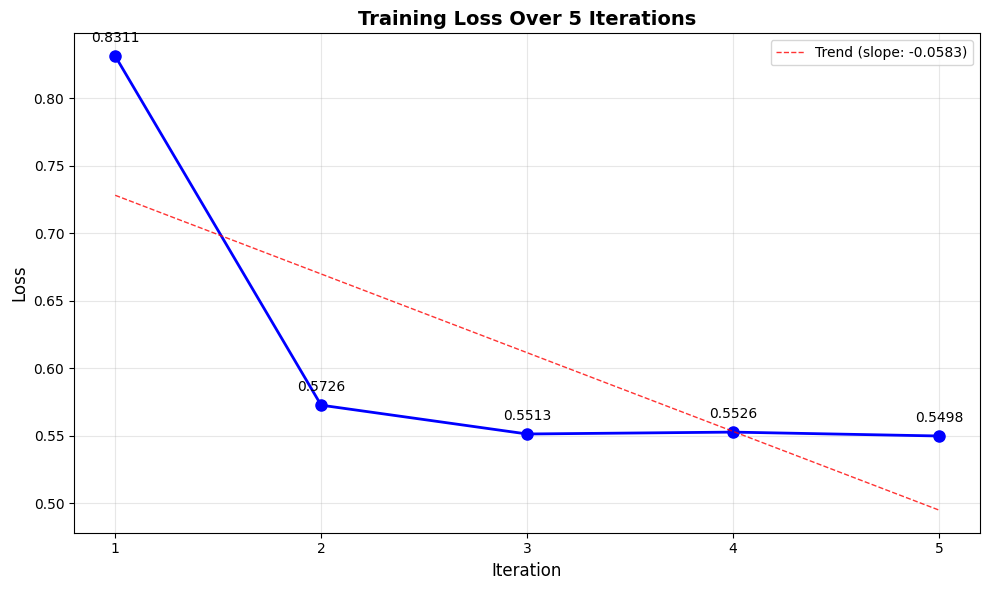


Training Analysis:
Initial loss: 0.8311
Final loss: 0.5498
Loss change: -0.2813
Percentage change: -33.85%
✓ Loss is decreasing - training is working!


In [25]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), losses, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over 5 Iterations', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, n_iterations + 1))

# Add value labels on each point
for i, loss in enumerate(losses):
    plt.annotate(f'{loss:.4f}', (i + 1, loss), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

# Add trend line
if len(losses) > 1:
    z = np.polyfit(range(1, n_iterations + 1), losses, 1)
    p = np.poly1d(z)
    plt.plot(range(1, n_iterations + 1), p(range(1, n_iterations + 1)), 
             "r--", alpha=0.8, linewidth=1, label=f'Trend (slope: {z[0]:.4f})')
    plt.legend()

plt.tight_layout()
plt.show()

# Analysis
print("\nTraining Analysis:")
print("=" * 20)
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss change: {losses[-1] - losses[0]:.4f}")
print(f"Percentage change: {((losses[-1] - losses[0]) / losses[0] * 100):.2f}%")

if losses[-1] < losses[0]:
    print("✓ Loss is decreasing - training is working!")
else:
    print("⚠ Loss is not decreasing - may need to adjust learning rate or model")


In [ ]:
# Additional analysis: Check gradient magnitudes and parameter updates
print("\nGradient and Parameter Analysis:")
print("=" * 40)

# Get final gradients
final_grads = []
for name, param in probe.named_parameters():
    if param.grad is not None:
        grad_norm = param.grad.norm().item()
        final_grads.append(grad_norm)
        print(f"{name:30s}: grad_norm = {grad_norm:.6f}")

print(f"\nGradient statistics:")
print(f"  Mean gradient norm: {np.mean(final_grads):.6f}")
print(f"  Max gradient norm: {np.max(final_grads):.6f}")
print(f"  Min gradient norm: {np.min(final_grads):.6f}")

# Check if gradients are reasonable (not too large or too small)
if np.max(final_grads) > 10:
    print("⚠ Large gradients detected - may cause instability")
elif np.max(final_grads) < 1e-6:
    print("⚠ Very small gradients - learning may be slow")
else:
    print("✓ Gradient magnitudes look reasonable")

# Test with different learning rates
print(f"\nTesting different learning rates:")
print("=" * 35)

learning_rates = [0.01, 0.001, 0.0001]
for lr in learning_rates:
    # Reset model
    probe_test = ClassificationProbe(
        d_esm=d_esm, c_dcc=c_dcc, d_shared=d_shared,
        n_classes=n_go_terms, d_go=16, p_emb=32, n_p=25
    )
    optimizer_test = optim.Adam(probe_test.parameters(), lr=lr)
    
    # Quick test with 3 iterations
    test_losses = []
    for i in range(3):
        optimizer_test.zero_grad()
        logits = probe_test(H_esm, H_dcc, lengths, go_embed)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer_test.step()
        test_losses.append(loss.item())
    
    print(f"LR {lr:6f}: {test_losses[0]:.4f} → {test_losses[-1]:.4f} (change: {test_losses[-1] - test_losses[0]:.4f})")
